The big benefit of NN based forecasting is the seemles integration of hierachical datastructures and additional variables. However, to start out with this forecasting task we will use a single series and a standard LSTM based network

In [1]:
import numpy as np 
import matplotlib.pyplot as plt
%matplotlib inline

import random
from torch.utils.data import Dataset,sampler,DataLoader
import torch
import torch.nn as nn


In [2]:
init=0.1
new=0

outlist=[init]
for j in range(1,2000):
    new=init+0.001*j-0.5*outlist[j-1]+np.random.normal(scale=0.1)
    outlist.append(new)

In [3]:
outlist=outlist[10:]

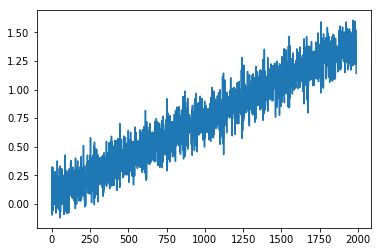

In [4]:
plt.plot(outlist)

In [5]:
series = [30,21,29,31,40,48,53,47,37,39,31,29,17,9,20,24,27,35,41,38,
          27,31,27,26,21,13,21,18,33,35,40,36,22,24,21,20,17,14,17,19,
          26,29,40,31,20,24,18,26,17,9,17,21,28,32,46,33,23,28,22,27,
          18,8,17,21,31,34,44,38,31,30,26,32]

In [6]:
train=series[:50]

In [7]:
test=series[50:]

In [8]:
class sequence_labeling_dataset(Dataset):
    
    def __init__(self, input,max_size=100,sequence_labeling=True,seasonality=12):     
        
        self.data=input
        self.max_size=max_size
        self.sequence_labeling=sequence_labeling
        self.seasonality=seasonality

    def __len__(self):
        
        return int(len(self.data))
    
    def __getitem__(self, index):
        
        data_i=self.data
        
        if len(data_i)>self.max_size:
            max_rand_int=len(data_i)-self.max_size
            #take a random start integer
            start_int=random.randint(0,max_rand_int)
            #return the random chunk of our data 
            data_i=data_i[start_int:(start_int+self.max_size)]

        #should be all but the last as the input 
        inp=np.array(data_i[:-1])
        
        #This is Sequence Classification
        if self.sequence_labeling==True:
            #this is sequence labeling
            out=np.array(data_i[1:])
        else:
            out=np.array(data_i[-1])
            
        init_shift=start_int

        k=int((init_shift-1)/self.seasonality)
        shift_steps=self.seasonality+init_shift-self.seasonality*(k+1)
        
        return inp, out,shift_steps
    

In [121]:
sl=sequence_labeling_dataset(train,12,False)
train_dl= DataLoader(dataset=sl,
                      batch_size=8,
                      shuffle=False
                      )
#We evaluate in sequence classification mode(its the only true forecast )
sl_t=sequence_labeling_dataset(test,12,False)
test_dl= DataLoader(dataset=sl_t,
                      batch_size=1,
                      shuffle=False
                      )


In [10]:
batch=next(iter(train_dl))

In [11]:
#This defines how much we have to shift the initial seasonality, given how much we shifted this random batch 
#this works for per series seasonalities only 
#Now we need a vecotrized version of shifting array 
#FUCKING NP ROLL IS  L I T 

In [12]:
class exponential_smoothing(torch.nn.Module):
    
    def __init__(self,init=0.1):
      
        super(exponential_smoothing, self).__init__()
        self.alpha=torch.nn.Parameter(torch.tensor(init))
        self.sig=nn.Sigmoid()
    def forward(self, series):
        
        result = [series[:,0]] # first value is same as series
        for n in range(1, series.shape[1]):
            result.append(self.sig(self.alpha) * series[:,n] + (1 - self.sig(self.alpha)) * result[n-1])        
            
        return torch.stack(result,dim=1)
    

In [13]:
#When we do batches we kind of have a weiered issue with learning initial values ! 
#because the trend shifts. 


In [14]:
forecast_steps=5
seasonality=7

In [15]:
k=int((forecast_steps-1)/seasonality)
#this is the past step we have to look at to get at correct seasonality step for for
#forecasting. 
past_step=forecast_steps-seasonality*(k+1)


In [16]:
#As we expected, if we randoml shift the input (for shuffeling purposes) We also have to shuft the 
#initial season appropriately, the quesiton is how exactly: 

In [112]:
class holt_winters(torch.nn.Module):
    
    def __init__(self,init_a=0.1,init_b=0.1,init_g=0.1,init_t=0.1,slen=12):
      
        super(holt_winters, self).__init__()
        
        self.alpha=torch.nn.Parameter(torch.tensor(init_a))
        self.beta=torch.nn.Parameter(torch.tensor(init_b))
        self.gamma=torch.nn.Parameter(torch.tensor(init))
        
        #self.alpha=torch.tensor(init_a)
        #self.beta=torch.tensor(init_b)
        #self.gamma=torch.tensor(init)
        
        self.init_season=torch.nn.Parameter(torch.tensor(np.random.random(size=slen)))
        self.init_trend=torch.nn.Parameter(torch.tensor(init))
        self.slen=slen
        self.sig=nn.Sigmoid()
        
    def forward(self,series ,n_preds,series_shifts):
        
        batch_size=series.shape[0]
        init_season_batch=self.init_season.repeat(batch_size).view(batch_size,-1)
        seasonals=init_season_batch.float()

        #align for different random shifts in the input (later for different series)
        seasonals=torch.stack([torch.roll(j,int(rol)) for j,rol in zip(init_season_batch,series_shifts)]).float()

        #we can work with lists instead, lets see if that helps :D 
        seasonals=list(torch.split(seasonals,1,dim=1))
        seasonals=[x.squeeze() for x in seasonals]

        #we need to put the seasonalities into 
        result = []

        for i in range(series.shape[1]+n_preds):

            if i == 0: 

                smooth = series[:,0]
                trend = self.init_trend.repeat(batch_size)

                result.append(series[:,0])

                continue

            #smoothing
            if i <series.shape[1]:

                val = series[:,i]

                last_smooth, smooth = smooth, self.sig(self.alpha)*(val-seasonals[i%self.slen]) + (1-self.sig(self.alpha))*(smooth+trend)

                trend = self.sig(self.beta) * (smooth-last_smooth) + (1-self.sig(self.beta))*trend
                seasonals[i%self.slen] = self.sig(self.gamma)*(val-smooth) + (1-self.sig(self.gamma))*seasonals[i%self.slen]

                result.append(smooth+trend+seasonals[i%self.slen])

            else:

                m = i - len(series) + 1
                result.append((smooth + m*trend) + seasonals[i%self.slen])

        return torch.stack(result,dim=1)
                

In [18]:
class self:
    pass

In [19]:
init_a=0.1
init_b=0.1
init_g=0.1
init_t=0.1
slen=12

In [92]:
self.alpha=torch.tensor(init_a)
self.beta=torch.tensor(init_b)
self.gamma=torch.nn.Parameter(torch.tensor(init))


self.init_season=torch.nn.Parameter(torch.tensor(np.random.random(size=slen)))
self.init_trend=torch.nn.Parameter(torch.tensor(init))
self.slen=slen
self.sig=nn.Sigmoid()

In [93]:
for batch in iter(train_dl):

    inp=batch[0].float()#.unsqueeze(2)
    out=batch[1].float()#.unsqueeze(2).float()
    shifts=batch[2].numpy()
    break

In [94]:
batch_size=series.shape[0]
init_season_batch=self.init_season.repeat(batch_size).view(batch_size,-1)
seasonals=init_season_batch.float()

#align for different random shifts in the input (later for different series)
seasonals=torch.stack([torch.roll(j,int(rol)) for j,rol in zip(init_season_batch,series_shifts)]).float()

#we can work with lists instead, lets see if that helps :D 
seasonals=list(torch.split(seasonals,1,dim=1))
seasonals=[x.squeeze() for x in seasonals]

#we need to put the seasonalities into 
result = []

for i in range(series.shape[1]+n_preds):

    if i == 0: 

        smooth = series[:,0]
        trend = self.init_trend.repeat(batch_size)

        result.append(series[:,0])

        continue

    #smoothing
    if i <series.shape[1]:

        val = series[:,i]
        
        last_smooth, smooth = smooth, self.sig(self.alpha)*(val-seasonals[i%self.slen]) + (1-self.sig(self.alpha))*(smooth+trend)
        
        trend = self.sig(self.beta) * (smooth-last_smooth) + (1-self.sig(self.beta))*trend
        seasonals[i%self.slen] = self.sig(self.gamma)*(val-smooth) + (1-self.sig(self.gamma))*seasonals[i%self.slen]

        result.append(smooth+trend+seasonals[i%self.slen])

    else:

        m = i - len(series) + 1
        result.append((smooth + m*trend) + seasonals[i%self.slen])

In [108]:
result[0].shape

torch.Size([8])

In [107]:
smooth.shape


torch.Size([8])

In [111]:
torch.stack(result,dim=1).shape

torch.Size([8, 13])

In [113]:
hw=holt_winters()

In [115]:
hw(inp,2,shifts)

torch.Size([8, 13])

In [58]:
preds=torch.stack(result)

In [59]:
pred=preds.permute(1,0)

In [60]:
out.shape

torch.Size([8])

In [61]:
loss=torch.mean(torch.abs(pred[:,-1]-out))


In [62]:
loss.backward()

In [69]:
hw=holt_winters()

In [81]:
tseries=torch.tensor(series).view(1,-1).float()

/home/leander/anaconda3/envs/pytorch/lib/python3.6/site-packages/ipykernel_launcher.py:1: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  """Entry point for launching an IPython kernel.


In [82]:
pred=hw(tseries,n_preds=2,series_shifts=[0])

In [83]:
pred=pred.detach().numpy()

In [411]:
class simple_lstm(torch.nn.Module):
    def __init__(self):
      
        super(simple_lstm, self).__init__()
        
        self.lstm=nn.LSTM(input_size=1,hidden_size=10)
        self.out_dense=nn.Linear(10,1)
        self.drop=nn.Dropout(0.2)
        self.simple_es=exponential_smoothing(0.1)
        
    def forward(self, x):
        
        
        #W ewould actually first smooth the input and use it to de level and deseasonalize
        #Lets strat with just deleveling 
        simple_smooth=self.simple_es(x)
        
        x=x/simple_smooth
        
        x=self.lstm(x)[0]
        #x=x[:,-1]
        #x=self.drop(x)
        x=self.out_dense(x)

        #here we can also Smooth alla holt winters, lets try! (also cool for the demo)
        
        
        return simple_smooth*x#

In [412]:
sl=simple_lstm()

In [140]:
sl=holt_winters()

In [141]:
opti = torch.optim.Adam(sl.parameters(), lr=0.001)#,weight_decay=0.0001

In [142]:
scheduler_plateau = torch.optim.lr_scheduler.ReduceLROnPlateau(opti, patience=2, verbose=True,mode="min",factor=0.1)

In [119]:
pred.shape

(12, 1)

In [127]:
pred.shape

torch.Size([8, 12])

In [146]:
for j in range(100):
    for batch in iter(train_dl):

        opti.zero_grad()
        inp=batch[0].float()#.unsqueeze(2)
        out=batch[1].float()#.unsqueeze(2).float()
        shifts=batch[2].numpy()
        #it returns the whole sequence atm 
        pred=sl(inp,1,shifts)[:,-1]
        loss=torch.mean(torch.abs(pred-out))

        loss.backward()
        opti.step()
        break
    testscore=[]
    
    for test_batch in iter(test_dl):
        test_inp=test_batch[0].float()
        test_out=test_batch[1].float().detach().numpy()
        shifts=batch[2].numpy()
        pred=sl(test_inp,1,shifts)
        pred=pred.detach().numpy()

        score=np.mean(np.abs(pred-test_out))
        testscore.append(score)
    score=np.mean(testscore)
    #scheduler_plateau.step(score)
    print(score)

16.175823
17.07532
14.534223
15.55252
16.589323
17.031395
17.194115
15.287876
15.164215
16.174025
13.9757805
16.426678
15.633739
15.288449
17.035128
16.301453
15.250156
14.542135
16.560364
15.622628
15.044153
15.670577
15.002921
15.391244
16.180162
18.324554
16.315939
15.165139
13.94067
16.788103
14.2987175
15.703443
15.343596
15.308991
15.088647
16.792744
15.279187
14.495621
14.459619
17.076462
15.37073
14.693439
14.680337
15.781128
14.749958
15.789628
17.492834
14.850077
15.549709
15.573047
15.704888
16.896172
15.105975
15.373231
17.384127
16.06681
14.583961
15.652542
15.631234
14.30524
15.61869
16.87848
16.975334
14.662805
15.622827
15.455216
15.975171
15.376847
14.469354
16.021832
15.669803
15.477317
16.020348
17.657824
16.382069
15.595334
15.723548
15.930911
16.059214
15.78605
15.634376
14.829192
16.826464
16.202494
15.087362
15.011677
14.933567
16.021564
16.608282
16.983538
16.04101
16.317518
15.497126
16.650307
14.990101
15.02954
15.067603
15.492992
14.529191
14.577961


In [147]:
params=[]
for param in sl.parameters():
    params.append(param)

In [144]:
params

[Parameter containing:
 tensor(0.1000, requires_grad=True), Parameter containing:
 tensor(0.1000, requires_grad=True), Parameter containing:
 tensor(0.1000, requires_grad=True), Parameter containing:
 tensor([0.6090, 0.7210, 0.9859, 0.5321, 0.0072, 0.6400, 0.1584, 0.2691, 0.5745,
         0.9017, 0.5735, 0.2989], dtype=torch.float64, requires_grad=True), Parameter containing:
 tensor(0.1000, requires_grad=True)]

In [148]:
params

[Parameter containing:
 tensor(0.0909, requires_grad=True), Parameter containing:
 tensor(0.0140, requires_grad=True), Parameter containing:
 tensor(0.1000, requires_grad=True), Parameter containing:
 tensor([0.6644, 0.7949, 1.0475, 0.6105, 0.0409, 0.5846, 0.1851, 0.2717, 0.5300,
         0.8223, 0.5092, 0.2767], dtype=torch.float64, requires_grad=True), Parameter containing:
 tensor(0.0458, requires_grad=True)]

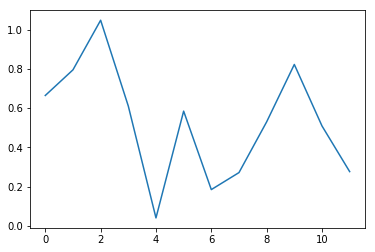

In [149]:
plt.plot(params[3].detach().numpy())

In [150]:
sl_t_2=sequence_labeling_dataset(test,12,True)
test_dl_2= DataLoader(dataset=sl_t_2,
                      batch_size=1,
                      shuffle=False
                      )

In [151]:
sl_t_2[0][1].shape

(11,)

In [152]:
sl_t_2[0]

(array([18,  8, 17, 21, 31, 34, 44, 38, 31, 30, 26]),
 array([ 8, 17, 21, 31, 34, 44, 38, 31, 30, 26, 32]),
 10)

In [153]:
test_batch=next(iter(test_dl_2))
test_inp=test_batch[0].unsqueeze(2).float()
test_out=test_batch[1].unsqueeze(2).float().detach().numpy()
shifts=batch[2].numpy()

pred=sl(test_inp,1,shifts)
pred=pred.detach().numpy()

In [156]:
test_inp.shape

torch.Size([1, 11, 1])

In [155]:
pred.shape

(1, 12, 1)

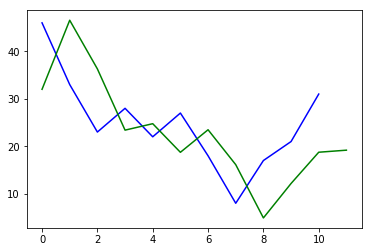

In [157]:
#lit
plt.plot(test_out[0,:,0], 'b') # plotting t, b separately 
plt.plot(pred[0,:,0], 'g') # plotting t, c separately 
plt.show()


In [361]:
from numpy import *
import math
import matplotlib.pyplot as plt

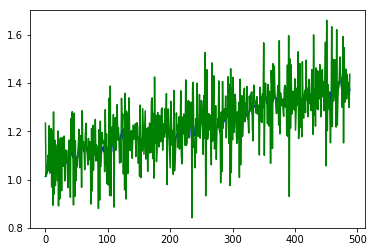

In [362]:
plt.plot(pred[0,:,0], 'b') # plotting t, b separately 
plt.plot(test_out[0,:,0], 'g') # plotting t, c separately 
plt.show()

In [ ]:
(pred[0,:,0])

In [ ]:
plt.plot(pred[0,:,0])